In [ ]:
"""
quantized_lora.ipynb

This script demonstrates post-training quantization of a ChemBERTa model fine-tuned with LoRA adapters.

Key Features:
- Fine-tunes ChemBERTa with LoRA on the ClinTox dataset.
- Exports the trained model to ONNX format.
- Applies dynamic quantization (QInt8) to the ONNX model, reducing model size and improving inference speed.
- Evaluates both baseline and quantized ONNX models on test accuracy and inference time.
- Plots and logs a side-by-side comparison of model size, test accuracy, and inference time.
"""

In [1]:
%%capture
!pip install deepchem transformers peft onnxruntime onnx

In [2]:
import warnings
import logging

warnings.filterwarnings("ignore", category=DeprecationWarning)
logging.getLogger("deepchem").setLevel(logging.ERROR)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import deepchem as dc
from peft import get_peft_model, LoraConfig, TaskType
import time
from sklearn.metrics import accuracy_score
from rdkit import Chem
import onnxruntime as ort
from onnxruntime.quantization import quantize_dynamic, QuantType
import random

random.seed(10)

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [4]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


True

In [5]:
# Define paths and parameters
MODEL_NAME = "seyonec/ChemBERTa-zinc-base-v1"
MAX_LENGTH = 128
BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 3e-4

# LoRA Configuration
LORA_R = 8  # Rank of LoRA
LORA_ALPHA = 16
LORA_DROPOUT = 0.1

In [6]:
class ClinToxDataset(Dataset):
    def __init__(self, data_path, tokenizer, split='train', max_length=128):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.split = split

        # Load ClinTox dataset from DeepChem
        tasks, datasets, transformers = dc.molnet.load_clintox()
        train_dataset, valid_dataset, test_dataset = datasets

        # Convert to SMILES and labels
        self.smiles_train, self.labels_train = self.remove_invalid_smiles(train_dataset.ids, train_dataset.y)
        self.smiles_valid, self.labels_valid = self.remove_invalid_smiles(valid_dataset.ids, valid_dataset.y)
        self.smiles_test, self.labels_test = self.remove_invalid_smiles(test_dataset.ids, test_dataset.y)

        # Set active split
        if split == 'train':
            self.smiles = self.smiles_train
            self.labels = self.labels_train
        elif split == 'valid':
            self.smiles = self.smiles_valid
            self.labels = self.labels_valid
        elif split == 'test':
            self.smiles = self.smiles_test
            self.labels = self.labels_test
        else:
            raise ValueError("Invalid split. Use 'train', 'valid', or 'test'.")

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        smiles = self.smiles[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            smiles,
            return_tensors="pt",
            max_length=self.max_length,
            padding="max_length",
            truncation=True
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.float)
        }

    def remove_invalid_smiles(self, smiles, labels):
        valid_indices = []
        for i, smile in enumerate(smiles):
            try:
                mol = Chem.MolFromSmiles(smile)
                if mol is not None:
                    valid_indices.append(i)
            except:
                pass

        return smiles[valid_indices], labels[valid_indices]

In [7]:
def setup_lora_model(model_name):
    """
    Set up a model with LoRA configuration
    """
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2,  # Binary classification for ClinTox
        return_dict=True
    )

    peft_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        inference_mode=False,
        r=LORA_R,
        lora_alpha=LORA_ALPHA,
        lora_dropout=LORA_DROPOUT,
        target_modules=["query", "value"]  # Target attention modules
    )

    model = get_peft_model(model, peft_config)
    return model

In [8]:
def train(model, tokenizer):

    wandb.init(
        project="testing",
        entity="hpml-proj-deepchem",
        name="LoRA_Training_inQuantization",
        config={
            "model_name": MODEL_NAME,
            "batch_size": BATCH_SIZE,
            "epochs": EPOCHS,
            "learning_rate": LEARNING_RATE,
            "lora_r": LORA_R,
            "lora_alpha": LORA_ALPHA,
            "lora_dropout": LORA_DROPOUT
        }
    )

    # Track model training
    wandb.watch(model, log="all", log_freq=10)

    # Create dataset for train split
    train_dataset = ClinToxDataset("clintox", tokenizer, split="train", max_length=MAX_LENGTH)

    # Create dataloader
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.BCEWithLogitsLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(EPOCHS):
        model.train()
        total_train_loss = 0
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}")

        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            loss = criterion(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            progress_bar.set_postfix({"loss": loss.item()})

        # Log training metrics per epoch
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": total_train_loss / len(train_dataloader)
        })

    wandb.finish()
    return model

In [9]:
def export(model, tokenizer, save_path, quantize=False):
    """
    Export a HuggingFace model to ONNX format. Optionally apply dynamic quantization.

    Args:
        model: Trained model to export.
        tokenizer: Associated tokenizer.
        save_path: Path to save the ONNX (or quantized) model.
        quantize: Whether to apply dynamic quantization (QInt8).
    """

    # Initialize wandb run
    run_name = "ONNX_Export_Quantized" if quantize else "ONNX_Export_Baseline"
    wandb.init(
        project="testing",
        entity="hpml-proj-deepchem",
        name=run_name,
        config={
            "model_name": MODEL_NAME,
            "quantized": quantize
        }
    )

    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Example input for tracing
    encoded = tokenizer(
        "CC(=O)Oc1ccccc1C(=O)O",  # SMILES example
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=128
    )
    input_ids = encoded["input_ids"].to(device)
    attention_mask = encoded["attention_mask"].to(device)

    # Use temp path if quantizing
    export_path = "temp_model.onnx" if quantize else save_path

    # Export to ONNX
    torch.onnx.export(
        model,
        (input_ids, attention_mask),
        export_path,
        input_names=["input_ids", "attention_mask"],
        output_names=["logits"],
        dynamic_axes={"input_ids": {0: "batch"}, "attention_mask": {0: "batch"}},
        opset_version=14
    )

    # Quantize if requested
    if quantize:
        quantize_dynamic(export_path, save_path, weight_type=QuantType.QInt8)
        os.remove(export_path)
        print(f"Quantized model saved to: {save_path}")
    else:
        print(f"Baseline ONNX model saved to: {save_path}")

    # Report model size
    size_mb = os.path.getsize(save_path) / (1024 * 1024)

    # Log model size
    wandb.log({"model_size_mb": size_mb})

    # Log model as artifact
    artifact = wandb.Artifact(
        name=f"onnx-model-{'quantized' if quantize else 'baseline'}",
        type="model",
        description=f"ONNX {'Quantized' if quantize else 'Baseline'} Model"
    )
    artifact.add_file(save_path)
    wandb.log_artifact(artifact)

    wandb.finish()

    model_size = round(size_mb, 2)
    print(f"Model size: {model_size} MB")

    return model_size


In [10]:
def evaluate_onnx_model(onnx_path):

    # Initialize wandb run
    is_quantized = "quant" in onnx_path
    run_name = "Evaluation_Quantized" if is_quantized else "Evaluation_Baseline_Not_Quantized"
    wandb.init(
        project="testing",
        entity="hpml-proj-deepchem",
        name=run_name,
        config={
            "model_path": onnx_path,
            "quantized": is_quantized
        }
    )

    session = ort.InferenceSession(onnx_path)

    test_dataset = ClinToxDataset("clintox", tokenizer, split="test", max_length=MAX_LENGTH)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    all_labels = []
    all_preds = []

    start_time = time.time()

    for batch in test_dataloader:
        input_ids = batch['input_ids'].numpy()
        attention_mask = batch['attention_mask'].numpy()
        labels = batch['labels'].numpy()

        # Run inference with ONNX
        ort_inputs = {
            "input_ids": input_ids,
            "attention_mask": attention_mask
        }
        ort_outs = session.run(None, ort_inputs)  # Returns a list; usually one element: logits

        logits = ort_outs[0]
        probs = 1 / (1 + np.exp(-logits))  # Sigmoid manually
        preds = (probs > 0.5).astype(int)

        all_preds.extend(preds)
        all_labels.extend(labels)

    end_time = time.time()
    total_time = round(end_time - start_time, 2)

    acc = round(accuracy_score(all_labels, all_preds), 4)

    print(f"Test Accuracy: {acc}")
    print(f"Total Inference Time: {total_time} s")

    # Log metrics
    wandb.log({
        "test_accuracy": acc,
        "inference_time": total_time
    })

    wandb.finish()

    return acc, total_time

In [11]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = setup_lora_model(MODEL_NAME)

trained_model = train(model, tokenizer)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/501 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/9.43k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/3.21k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/179M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

[18:28:44] DEPRECATION WARNING: please use MorganGenerator
[18:28:44] DEPRECATION WARNING: please use MorganGenerator
[18:28:44] DEPRECATION WARNING: please use MorganGenerator
[18:28:44] DEPRECATION WARNING: please use MorganGenerator
[18:28:44] DEPRECATION WARNING: please use MorganGenerator
[18:28:44] DEPRECATION WARNING: please use MorganGenerator
[18:28:44] DEPRECATION WARNING: please use MorganGenerator
[18:28:44] Explicit valence for atom # 0 N, 4, is greater than permitted
[18:28:44] DEPRECATION WARNING: please use MorganGenerator
[18:28:44] DEPRECATION WARNING: please use MorganGenerator
[18:28:44] DEPRECATION WARNING: please use MorganGenerator
[18:28:44] DEPRECATION WARNING: please use MorganGenerator
[18:28:44] DEPRECATION WARNING: please use MorganGenerator
[18:28:44] DEPRECATION WARNING: please use MorganGenerator
[18:28:44] DEPRECATION WARNING: please use MorganGenerator
[18:28:44] DEPRECATION WARNING: please use MorganGenerator
[18:28:44] DEPRECATION WARNING: please use

epoch,▁▃▅▆█
train_loss,█▃▂▂▁
epoch,5
train_loss,0.04127


In [12]:
baseline_size = export(trained_model, tokenizer, save_path="model-baseline.onnx", quantize=False)

baseline_acc, baseline_time = evaluate_onnx_model("model-baseline.onnx")

Baseline ONNX model saved to: model-baseline.onnx


model_size_mb,▁
model_size_mb,169.01791


Model size: 169.02 MB


Test Accuracy: 0.9797
Total Inference Time: 4.15 s


inference_time,▁
test_accuracy,▁
inference_time,4.15
test_accuracy,0.9797


In [13]:
quantized_size = export(trained_model, tokenizer, save_path="model-quant.onnx", quantize=True)

quantized_acc, quantized_time = evaluate_onnx_model("model-quant.onnx")

Quantized model saved to: model-quant.onnx


model_size_mb,▁
model_size_mb,42.75441


Model size: 42.75 MB


Test Accuracy: 0.9797
Total Inference Time: 1.69 s


inference_time,▁
test_accuracy,▁
inference_time,1.69
test_accuracy,0.9797


In [14]:
def plot_model_comparison(baseline_metrics, quantized_metrics):
    """
    Create a visualization comparing baseline and quantized models.

    Args:
        baseline_metrics: Dict with 'size_mb', 'accuracy', 'inference_time'
        quantized_metrics: Dict with 'size_mb', 'accuracy', 'inference_time'
    """
    # Initialize wandb
    wandb.init(
        project="testing",
        entity="hpml-proj-deepchem",
        name="Quantization_Model_Comparison_Visualization"
    )

    # Extract metrics
    models = ["Baseline", "Quantized"]
    sizes = [baseline_metrics["size_mb"], quantized_metrics["size_mb"]]
    accuracies = [baseline_metrics["accuracy"], quantized_metrics["accuracy"]]
    times = [baseline_metrics["inference_time"], quantized_metrics["inference_time"]]

    # Create subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Model Size subplot
    axs[0].bar(models, sizes, color=['blue', 'green'])
    axs[0].set_title('Model Size (MB)')
    axs[0].set_ylabel('Size (MB)')

    # Test Accuracy subplot
    axs[1].bar(models, accuracies, color=['blue', 'green'])
    axs[1].set_title('Test Accuracy')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_ylim(0, 1)

    # Inference Time subplot
    axs[2].bar(models, times, color=['blue', 'green'])
    axs[2].set_title('Inference Time (s)')
    axs[2].set_ylabel('Time (seconds)')

    plt.tight_layout()

    # Log plot to wandb
    wandb.log({"model_comparison": wandb.Image(fig)})

    # Also log as table
    comparison_table = wandb.Table(columns=["Model", "Size (MB)", "Accuracy", "Inference Time (s)"])
    comparison_table.add_data("Baseline", baseline_metrics["size_mb"], baseline_metrics["accuracy"], baseline_metrics["inference_time"])
    comparison_table.add_data("Quantized", quantized_metrics["size_mb"], quantized_metrics["accuracy"], quantized_metrics["inference_time"])
    wandb.log({"comparison_table": comparison_table})

    wandb.finish()

    plt.show()

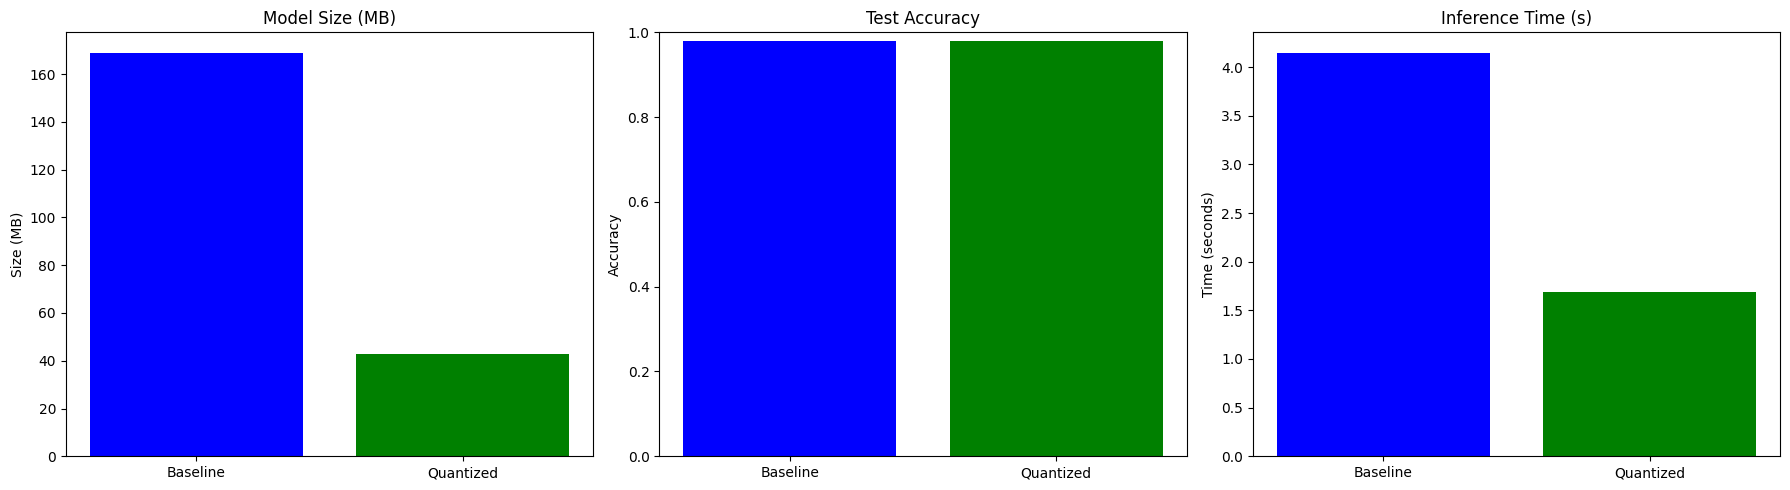

In [15]:
baseline_metrics = {
    "size_mb": baseline_size,
    "accuracy": baseline_acc,
    "inference_time": baseline_time
}

quantized_metrics = {
    "size_mb": quantized_size,
    "accuracy": quantized_acc,
    "inference_time": quantized_time
}

plot_model_comparison(baseline_metrics, quantized_metrics)